Using device: cuda: NVIDIA L4
[load_data] users=51829 items=10000 train_pos=843959 test_users=51829 took 2.9s

===== Running POP =====
[POP] saved -> /content/partD_outputs/metrics_pop.csv

===== Running NEUMF =====
[NeuMF] Epoch 1: loss=0.4330 HR@10=0.5124 NDCG@10=0.3097 (74.9s)
[NeuMF] Epoch 2: loss=0.2548 HR@10=0.7457 NDCG@10=0.5054 (73.2s)
[NeuMF] Epoch 3: loss=0.1822 HR@10=0.7980 NDCG@10=0.5655 (73.1s)
[NEUMF] saved -> /content/partD_outputs/metrics_neumf.csv

===== Running SSR =====
[SSR]  Epoch 1: loss=15.7541 HR@10=0.0920 NDCG@10=0.0426 (116.5s)
[SSR]  Epoch 2: loss=9.9157 HR@10=0.0871 NDCG@10=0.0399 (114.9s)
[SSR]  Epoch 3: loss=9.3602 HR@10=0.0824 NDCG@10=0.0373 (115.4s)
[SSR] saved -> /content/partD_outputs/metrics_ssr.csv

===== Running LIGHTGCN =====
[LightGCN] Epoch 1: loss=0.5391 HR@10=0.5020 NDCG@10=0.2813 (1452.4s)
[LightGCN] Epoch 2: loss=0.3308 HR@10=0.6365 NDCG@10=0.3845 (1452.3s)
[LightGCN] Epoch 3: loss=0.2516 HR@10=0.6869 NDCG@10=0.4275 (1452.6s)
[LIGHTGCN] saved

,epoch,HR@K,NDCG@K,Precision@K,Recall@K,MRR@K,MAP@K,Coverage@K,Novelty(bits),GiniPicked,TailCov@K,model,loss
0,0.0,0.023269,0.008918,0.002327,0.023269,0.004781,0.004781,0.2195,13.100154,0.494419,0.000000,pop,NaN
1,3.0,0.798047,0.565546,0.079805,0.798047,0.492789,0.492789,0.9997,13.394258,0.458354,0.375298,neumf,0.182153
2,3.0,0.082444,0.037316,0.008244,0.082444,0.023975,0.023975,0.5515,13.208295,0.655213,0.046542,ssr,9.360241
3,3.0,0.686893,0.427489,0.068689,0.686893,0.347272,0.347272,0.9860,13.350211,0.448215,0.305626,lightgcn,0.251558


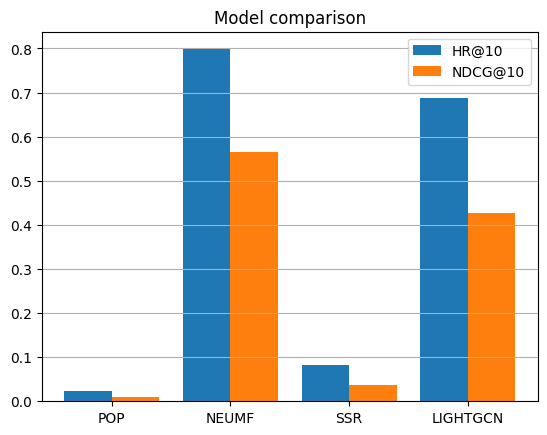

[segments] saved -> /content/partD_outputs/segment_eval.json
[best] by NDCG@10: neumf
[previews] saved -> /content/partD_outputs/example_recommendations_neumf.json
Artifacts -> /content/partD_outputs


,epoch,HR@K,NDCG@K,Precision@K,Recall@K,MRR@K,MAP@K,Coverage@K,Novelty(bits),GiniPicked,TailCov@K,model,loss
0,0.0,0.023269,0.008918,0.002327,0.023269,0.004781,0.004781,0.2195,13.100154,0.494419,0.000000,pop,NaN
1,3.0,0.798047,0.565546,0.079805,0.798047,0.492789,0.492789,0.9997,13.394258,0.458354,0.375298,neumf,0.182153
2,3.0,0.082444,0.037316,0.008244,0.082444,0.023975,0.023975,0.5515,13.208295,0.655213,0.046542,ssr,9.360241
3,3.0,0.686893,0.427489,0.068689,0.686893,0.347272,0.347272,0.9860,13.350211,0.448215,0.305626,lightgcn,0.251558


In [ ]:
import os, time, json, random, math
from types import SimpleNamespace
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# GPU & Reproducibility
def print_gpu_and_set_precision():
    dev = "cpu"
    if torch.cuda.is_available():
        name = torch.cuda.get_device_name(0)
        dev = f"cuda: {name}"
    print("Using device:", dev)
    if torch.cuda.is_available():
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        try:
            torch.set_float32_matmul_precision('high')
        except Exception:
            pass
        torch.backends.cudnn.benchmark = True

def amp_dtype_and_scaler():
    use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    amp_dtype = torch.bfloat16 if use_bf16 else torch.float16
    scaler = torch.amp.GradScaler("cuda", enabled=(not use_bf16) and torch.cuda.is_available())
    return amp_dtype, scaler

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def dl_kwargs(num_workers=4):
    kw = dict(num_workers=num_workers, pin_memory=True)
    if num_workers > 0:
        kw.update(dict(persistent_workers=True, prefetch_factor=2))
    return kw

def build_adamw(params, lr, weight_decay=0.0):
    try:
        return optim.AdamW(params, lr=lr, weight_decay=weight_decay, fused=True)
    except TypeError:
        return optim.AdamW(params, lr=lr, weight_decay=weight_decay)

# Metrics
def topk_metrics(ranked, gt, k=10):
    try:
        idx = ranked.index(gt)
        in_top = (idx < k)
        hit = 1 if in_top else 0
        ndcg = (1.0/np.log2(idx+2)) if in_top else 0.0
        prec = (1.0/k) if in_top else 0.0
        rec  = 1.0 if in_top else 0.0
        mrr  = (1.0/(idx+1)) if in_top else 0.0
        ap   = (1.0/(idx+1)) if in_top else 0.0
    except ValueError:
        hit=ndcg=prec=rec=mrr=ap=0.0
    return hit, ndcg, prec, rec, mrr, ap

def gini_coefficient(counts):
    x = np.sort(np.array(counts, dtype=float))
    if x.sum() == 0: return 0.0
    n = len(x); cumx = np.cumsum(x)
    return (n + 1 - 2 * (cumx.sum() / cumx[-1])) / n

# Data
def load_data(data_dir, rating_threshold=3.0, max_len=50, verbose=True):
    t0=time.time()
    ratings = pd.read_csv(f"{data_dir}/ratings.csv")
    if not {'user_id','book_id','rating'}.issubset(ratings.columns):
        raise ValueError("ratings.csv must have columns: user_id, book_id, rating (timestamp optional)")
    ratings = ratings[ratings['rating'] >= rating_threshold].copy()

    u_map0 = {u:i for i,u in enumerate(ratings['user_id'].unique())}
    i_map0 = {i:j for j,i in enumerate(ratings['book_id'].unique())}
    ratings['u0'] = ratings['user_id'].map(u_map0)
    ratings['i0'] = ratings['book_id'].map(i_map0)

    sort_cols = ['u0'] + (['timestamp'] if 'timestamp' in ratings.columns else [])
    ratings = ratings.sort_values(sort_cols)

    user_pos0 = defaultdict(set)
    seq0      = defaultdict(list)
    test0     = {}
    for u, g in ratings.groupby('u0'):
        items = list(g['i0'])
        if len(items) < 2: continue
        test0[u] = items[-1]
        for it in items[:-1]:
            user_pos0[u].add(it)
            seq0[u].append(it)

    kept = sorted(user_pos0.keys())
    u_new = {u:i for i,u in enumerate(kept)}
    user_pos = {u_new[u]: set(items) for u, items in user_pos0.items()}
    sequences= {u_new[u]: seq[:]      for u, seq   in seq0.items()}
    test     = {u_new[u]: it          for u, it    in test0.items()}
    num_users= len(u_new)
    num_items= int(max(i_map0.values()) + 1) if len(i_map0)>0 else 0

    # SSR sequences limited to max_len
    for u in list(sequences.keys()):
        sequences[u] = sequences[u][-max_len:]

    if verbose:
        print(f"[load_data] users={num_users} items={num_items} "
              f"train_pos={sum(len(s) for s in user_pos.values())} "
              f"test_users={len(test)} took {time.time()-t0:.1f}s")
    return user_pos, sequences, test, num_users, num_items

def build_popularity(user_pos, num_items):
    pop = np.zeros(num_items, dtype=np.int64)
    for _, pos in user_pos.items():
        for i in pos: pop[i]+=1
    return pop

# Datasets
class TripletDataset(Dataset):
    def __init__(self, triplets): self.triplets = triplets
    def __len__(self): return len(self.triplets)
    def __getitem__(self, idx): u,p,n = self.triplets[idx]; return u,p,n

def triplets_negative_sampling(user_pos, num_items, neg_ratio=1):
    trip=[]
    for u, pos in user_pos.items():
        for p in pos:
            for _ in range(neg_ratio):
                while True:
                    n = random.randint(0, num_items-1)
                    if n not in pos and n != p:
                        trip.append((u,p,n)); break
    return trip

def neumf_pointwise_dataset(user_pos, num_items, neg_ratio=4):
    rows=[]
    for u, pos in user_pos.items():
        pos = list(pos)
        for p in pos:
            rows.append((u,p,1))
        need = neg_ratio * len(pos)
        if need == 0: continue
        negs=[]; tried=0
        while len(negs) < need and tried < need*10:
            cand = np.random.randint(0, num_items, size=need-len(negs))
            for n in cand:
                if n not in user_pos[u]:
                    negs.append(int(n))
            tried += 1
        negs = negs[:need]
        for n in negs: rows.append((u,n,0))
    arr = np.array(rows, dtype=np.int64)
    return TensorDataset(torch.from_numpy(arr[:,0]).long(),
                         torch.from_numpy(arr[:,1]).long(),
                         torch.from_numpy(arr[:,2]).float())

# Models
class NeuMFLogits(nn.Module):
    """NCF/NeuMF returning logits."""
    def __init__(self, num_users, num_items, emb=64, mlp_layers=(256,128), dropout=0.15):
        super().__init__()
        self.gmf_u = nn.Embedding(num_users, emb)
        self.gmf_i = nn.Embedding(num_items, emb)
        self.mlp_u = nn.Embedding(num_users, emb)
        self.mlp_i = nn.Embedding(num_items, emb)
        layers=[]; inp = emb*2
        for h in mlp_layers:
            layers += [nn.Linear(inp, h), nn.ReLU()]
            if dropout>0: layers += [nn.Dropout(dropout)]
            inp = h
        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(emb + mlp_layers[-1], 1)
        for t in [self.gmf_u, self.gmf_i, self.mlp_u, self.mlp_i]:
            nn.init.normal_(t.weight, std=0.01)
    def forward(self, users, items):
        gmf = self.gmf_u(users) * self.gmf_i(items)
        mlp = torch.cat([self.mlp_u(users), self.mlp_i(items)], dim=1)
        mlp = self.mlp(mlp)
        x = torch.cat([gmf, mlp], dim=1)
        return self.out(x).squeeze(-1)  # logits
    def predict(self, users, items): return self.forward(users, items)

class SASRecSSR(nn.Module):
    def __init__(self, num_items, max_len=50, d_model=64, n_heads=2, n_blocks=2, dropout=0.2):
        super().__init__()
        self.num_items = num_items
        self.max_len   = max_len
        self.item_emb  = nn.Embedding(num_items+1, d_model, padding_idx=0)  # 0 = PAD
        self.pos_emb   = nn.Embedding(max_len, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_blocks)
    def forward(self, seqs):
        b, L = seqs.shape
        pos = torch.arange(L, device=seqs.device).unsqueeze(0).expand(b, -1)
        x = self.item_emb(seqs) + self.pos_emb(pos)
        mask = torch.triu(torch.ones(L, L, device=seqs.device), diagonal=1).bool()
        h = self.encoder(x, mask=mask)[:, -1, :]
        logits = torch.matmul(h, self.item_emb.weight[1:].T)
        return logits

class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, emb=64, layers=3):
        super().__init__()
        self.layers = layers
        self.num_users = num_users
        self.user_emb = nn.Embedding(num_users, emb)
        self.item_emb = nn.Embedding(num_items, emb)
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
    def propagate(self, edge_index):
        users = self.user_emb.weight
        items = self.item_emb.weight
        all_e = torch.cat([users, items], dim=0)
        outs=[all_e]
        for _ in range(self.layers):
            src, dst = edge_index
            deg = torch.zeros(all_e.size(0), device=all_e.device)
            deg.index_add_(0, src, torch.ones_like(src, dtype=torch.float))
            deg[deg==0] = 1
            agg = torch.zeros_like(all_e)
            agg.index_add_(0, src, all_e[dst] / deg[src].unsqueeze(1))
            all_e = agg
            outs.append(all_e)
        return torch.stack(outs, dim=1).mean(dim=1)
    def forward(self, users, items, edge_index):
        all_e = self.propagate(edge_index)
        ue = all_e[users]
        ie = all_e[self.num_users + items]
        return (ue*ie).sum(dim=1)
    def predict(self, users, items, edge_index): return self.forward(users, items, edge_index)

# Graph & Evaluation (SSR input shift applied)
def build_edge_index(user_pos, num_users, num_items):
    src, dst = [], []
    for u, pos in user_pos.items():
        for i in pos:
            src.append(u);            dst.append(num_users + i)
            src.append(num_users + i); dst.append(u)
    return torch.tensor(src, dtype=torch.long), torch.tensor(dst, dtype=torch.long)

def evaluate(model, model_type, test_data, user_pos, num_items, device,
             k=10, sequences=None, edge_index=None, max_len=50, alpha_pop=0.0, pop_scores=None):
    needs_eval = (model_type != "pop" and model is not None)
    if needs_eval: model.eval()

    hr=ndcg=prec=rec=mrr=mapk=0.0
    coverage=set(); picked=[]
    users = list(test_data.keys())

    with torch.no_grad():
        for u in users:
            gt = test_data[u]
            negs=set()
            while len(negs)<99:
                n=np.random.randint(0, num_items)
                if n not in user_pos[u] and n!=gt: negs.add(int(n))
            items = list(negs) + [gt]

            if model_type == "lightgcn":
                ut = torch.tensor([u]*len(items), dtype=torch.long, device=device)
                it = torch.tensor(items, dtype=torch.long, device=device)
                scores = model.predict(ut, it, edge_index).detach().cpu().numpy()

            elif model_type == "ssr":
                # shift history by +1 so PAD=0, items=1..num_items
                hist_raw = sequences.get(u, []) if sequences else []
                hist = [x+1 for x in hist_raw]
                seq = [0]*(max_len-len(hist)) + hist[-max_len:]
                logits = model(torch.tensor([seq], dtype=torch.long, device=device)).squeeze(0)
                # logits columns correspond to original items 0..num_items-1
                scores = logits[torch.tensor(items, dtype=torch.long, device=device)].detach().cpu().numpy()

            elif model_type == "pop":
                scores = np.array([pop_scores[i] for i in items], dtype=np.float32)

            else:  # NeuMF
                ut = torch.tensor([u]*len(items), dtype=torch.long, device=device)
                it = torch.tensor(items, dtype=torch.long, device=device)
                scores = model.predict(ut, it).detach().cpu().numpy()

            if alpha_pop!=0.0 and pop_scores is not None:
                pop_adj = np.array([pop_scores[i] for i in items], dtype=np.float32)
                pop_adj = (pop_adj - pop_adj.min()) / (pop_adj.max() - pop_adj.min() + 1e-8)
                scores = (1-alpha_pop)*scores + alpha_pop*pop_adj

            ranked = [items[i] for i in np.argsort(-scores)]
            coverage.update(ranked[:k]); picked.extend(ranked[:k])
            h,n,p,r,rr,ap = topk_metrics(ranked, gt, k)
            hr+=h; ndcg+=n; prec+=p; rec+=r; mrr+=rr; mapk+=ap

    denom = max(1,len(users))
    cov = len(coverage) / max(1,num_items)
    novelty = gini = tail = None
    if pop_scores is not None and len(picked)>0:
        total = pop_scores.sum()
        p = np.maximum(pop_scores/ max(1,total), 1e-12)
        info = -np.log2(p)
        novelty = float(np.mean([info[i] for i in picked]))
        counts = Counter(picked)
        gini = gini_coefficient(list(counts.values()))
        thr = np.quantile(pop_scores, 0.2)
        tail = sum(1 for i in picked if pop_scores[i] <= thr) / len(picked)

    return {
        "HR@K": hr/denom, "NDCG@K": ndcg/denom, "Precision@K": prec/denom,
        "Recall@K": rec/denom, "MRR@K": mrr/denom, "MAP@K": mapk/denom,
        "Coverage@K": cov, "Novelty(bits)": novelty, "GiniPicked": gini, "TailCov@K": tail
    }

def evaluate_segments(model, model_type, test_data, user_pos, sequences, num_items, device,
                      k=10, max_len=50, edge_index=None, alpha_pop=0.0, pop_scores=None):
    buckets = {"sparse": [], "medium": [], "dense": []}
    for u, pos in user_pos.items():
        L = len(pos)
        if   L<=4:  buckets["sparse"].append(u)
        elif L<=20: buckets["medium"].append(u)
        else:       buckets["dense"].append(u)
    out={}
    for name, users in buckets.items():
        sub_test = {u:test_data[u] for u in users if u in test_data}
        if not sub_test:
            out[name]=None; continue
        out[name]=evaluate(model, model_type, sub_test, user_pos, num_items, device, k,
                           sequences, edge_index, max_len, alpha_pop, pop_scores)
    return out

# Training Loops
def train_neumf(args, user_pos, test_data, num_users, num_items, device, k, outdir, alpha_pop, pop_scores,
                amp_dtype, scaler):
    model = NeuMFLogits(num_users, num_items, emb=args.embedding_dim,
                        mlp_layers=args.neumf_layers, dropout=args.neumf_dropout).to(device)
    criterion = nn.BCEWithLogitsLoss()
    opt = build_adamw(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    logs=[]
    for e in range(1, args.epochs+1):
        ds = neumf_pointwise_dataset(user_pos, num_items, neg_ratio=args.neumf_neg_ratio)
        loader = DataLoader(ds, batch_size=args.batch_size, shuffle=True, **dl_kwargs(args.num_workers))
        model.train(); total=0.0; t0=time.time()
        for users, items, labels in loader:
            users, items, labels = users.to(device, non_blocking=True), items.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", dtype=amp_dtype, enabled=torch.cuda.is_available()):
                logits = model(users, items)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            total += loss.item()
        res = evaluate(model, "neumf", test_data, user_pos, num_items, device, k,
                       sequences=None, edge_index=None, alpha_pop=alpha_pop, pop_scores=pop_scores)
        logs.append({"epoch":e, "loss":total/len(loader), **res})
        print(f"[NeuMF] Epoch {e}: loss={total/len(loader):.4f} HR@{k}={res['HR@K']:.4f} NDCG@{k}={res['NDCG@K']:.4f} ({time.time()-t0:.1f}s)")
    df = pd.DataFrame(logs); path = os.path.join(outdir, "metrics_neumf.csv"); df.to_csv(path, index=False)
    print(f"[NEUMF] saved -> {path}")
    return df, model

def train_ssr(args, user_pos, sequences, test_data, num_items, device, k, outdir, alpha_pop, pop_scores,
              amp_dtype, scaler):
    model = SASRecSSR(num_items, max_len=args.max_seq_len, d_model=args.embedding_dim,
                      n_heads=args.ssr_heads, n_blocks=args.ssr_blocks, dropout=args.ssr_dropout).to(device)
    criterion = nn.CrossEntropyLoss()

    # Build pairs
    data=[]
    for _, seq in sequences.items():
        if len(seq) < 2: continue
        seq_in = [x+1 for x in seq]  # shift inputs by +1 (PAD=0)
        for t in range(1, len(seq_in)):
            hist = seq_in[:t][-args.max_seq_len:]   # shifted history as input
            target = seq[t]                          # original item id 0..num_items-1
            data.append((hist, target))
    if len(data)==0:
        print("[SSR] No sequential training pairs; skipping.")
        df = pd.DataFrame([{"epoch":0, "loss":None, **evaluate(None, "pop", test_data, user_pos, num_items, device, k, None, None, args.max_seq_len, 0.0, pop_scores)}])
        path = os.path.join(outdir, "metrics_ssr.csv"); df.to_csv(path, index=False)
        return df, None

    def pad(seq, L): return [0]*(L-len(seq)) + seq[-L:]
    X = torch.tensor([pad(s, args.max_seq_len) for s,_ in data], dtype=torch.long)
    y = torch.tensor([t for _,t in data], dtype=torch.long)
    loader = DataLoader(TensorDataset(X,y), batch_size=args.batch_size, shuffle=True,
                        **dl_kwargs(max(1,args.num_workers//2)))

    logs=[]; opt = build_adamw(model.parameters(), lr=args.lr, weight_decay=0.0)
    for e in range(1, args.epochs+1):
        t0=time.time(); model.train(); total=0.0
        for xb, yb in loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", dtype=amp_dtype, enabled=torch.cuda.is_available()):
                logits = model(xb)       # [B, num_items]
                loss   = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            total += loss.item()
        res = evaluate(model, "ssr", test_data, user_pos, num_items, device, k,
                       sequences=sequences, edge_index=None, max_len=args.max_seq_len,
                       alpha_pop=alpha_pop, pop_scores=pop_scores)
        logs.append({"epoch":e, "loss":total/len(loader), **res})
        print(f"[SSR]  Epoch {e}: loss={total/len(loader):.4f} HR@{k}={res['HR@K']:.4f} NDCG@{k}={res['NDCG@K']:.4f} ({time.time()-t0:.1f}s)")
    df = pd.DataFrame(logs); path = os.path.join(outdir, "metrics_ssr.csv"); df.to_csv(path, index=False)
    print(f"[SSR] saved -> {path}")
    return df, model

def train_lightgcn(args, user_pos, test_data, num_users, num_items, device, k, outdir, alpha_pop, pop_scores,
                   amp_dtype, scaler):
    model = LightGCN(num_users, num_items, emb=args.embedding_dim, layers=args.gc_layers).to(device)
    trip = triplets_negative_sampling(user_pos, num_items, neg_ratio=args.neg_ratio)
    loader = DataLoader(TripletDataset(trip), batch_size=args.batch_size, shuffle=True, **dl_kwargs(args.num_workers))
    opt = build_adamw(model.parameters(), lr=args.lr, weight_decay=0.0)
    ei = build_edge_index(user_pos, num_users, num_items)
    edge_index = (ei[0].to(device), ei[1].to(device))
    logs=[]
    for e in range(1, args.epochs+1):
        t0=time.time(); model.train(); total=0.0
        for u,p,n in loader:
            u,p,n = u.to(device, non_blocking=True), p.to(device, non_blocking=True), n.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", dtype=amp_dtype, enabled=torch.cuda.is_available()):
                pos = model.predict(u, p, edge_index)
                neg = model.predict(u, n, edge_index)
                loss = -torch.log(torch.sigmoid(pos - neg)).mean()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            total += loss.item()
        res = evaluate(model, "lightgcn", test_data, user_pos, num_items, device, k,
                       sequences=None, edge_index=edge_index, alpha_pop=alpha_pop, pop_scores=pop_scores)
        logs.append({"epoch":e, "loss":total/len(loader), **res})
        print(f"[LightGCN] Epoch {e}: loss={total/len(loader):.4f} HR@{k}={res['HR@K']:.4f} NDCG@{k}={res['NDCG@K']:.4f} ({time.time()-t0:.1f}s)")
    df = pd.DataFrame(logs); path = os.path.join(outdir, "metrics_lightgcn.csv"); df.to_csv(path, index=False)
    print(f"[LIGHTGCN] saved -> {path}")
    return df, model, edge_index

def run_pop(user_pos, test_data, num_items, device, k, outdir, alpha_pop, pop_scores):
    res = evaluate(None, "pop", test_data, user_pos, num_items, device, k,
                   sequences=None, edge_index=None, alpha_pop=alpha_pop, pop_scores=pop_scores)
    df = pd.DataFrame([{"epoch":0, **res}])
    path = os.path.join(outdir, "metrics_pop.csv"); df.to_csv(path, index=False)
    print(f"[POP] saved -> {path}")
    return df, None

# pipeline to run
def run_pipeline(ARGS):
    set_seed(ARGS.seed)
    print_gpu_and_set_precision()
    os.makedirs(ARGS.results_dir, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() and not ARGS.cpu else 'cpu')

    user_pos, sequences, test, num_users, num_items = load_data(ARGS.data_dir, ARGS.rating_threshold, ARGS.max_seq_len)
    pop_scores = build_popularity(user_pos, num_items)
    amp_dtype, scaler = amp_dtype_and_scaler()

    models = []
    if ARGS.run_pop:      models.append("pop")
    if ARGS.run_neumf:    models.append("neumf")
    if ARGS.run_ssr:      models.append("ssr")
    if ARGS.run_lightgcn: models.append("lightgcn")

    all_last=[]; objs={}; lgn_ei=None

    for m in models:
        print(f"\n===== Running {m.upper()} =====")
        if m=="pop":
            df, obj = run_pop(user_pos, test, num_items, device, ARGS.k, ARGS.results_dir, ARGS.alpha_pop, pop_scores)
        elif m=="neumf":
            df, obj = train_neumf(ARGS, user_pos, test, num_users, num_items, device, ARGS.k,
                                  ARGS.results_dir, ARGS.alpha_pop, pop_scores, amp_dtype, scaler)
        elif m=="ssr":
            df, obj = train_ssr(ARGS, user_pos, sequences, test, num_items, device, ARGS.k,
                                ARGS.results_dir, ARGS.alpha_pop, pop_scores, amp_dtype, scaler)
        elif m=="lightgcn":
            df, obj, lgn_ei = train_lightgcn(ARGS, user_pos, test, num_users, num_items, device, ARGS.k,
                                             ARGS.results_dir, ARGS.alpha_pop, pop_scores, amp_dtype, scaler)
        objs[m]=obj
        last = df.iloc[-1].to_dict(); last['model']=m; all_last.append(last)

    summary = pd.DataFrame(all_last)
    sp = os.path.join(ARGS.results_dir, "summary_all_models.csv"); summary.to_csv(sp, index=False)
    print("\n[summary] saved ->", sp); display(summary)

    # comparison plot
    xs = np.arange(len(models)); hr = [summary[summary['model']==m]['HR@K'].values[-1] for m in models]
    nd = [summary[summary['model']==m]['NDCG@K'].values[-1] for m in models]
    plt.figure(); w=0.4
    plt.bar(xs - w/2, hr, width=w, label=f"HR@{ARGS.k}")
    plt.bar(xs + w/2, nd, width=w, label=f"NDCG@{ARGS.k}")
    plt.xticks(xs, [m.upper() for m in models]); plt.title("Model comparison"); plt.grid(True, axis='y'); plt.legend(); plt.show()

    # segment evaluation
    seg_results={}
    for m in models:
        edge_index = lgn_ei if m=="lightgcn" else None
        seg_results[m] = evaluate_segments(
            objs.get(m), m, test, user_pos, sequences, num_items, device,
            k=ARGS.k, max_len=ARGS.max_seq_len, edge_index=edge_index,
            alpha_pop=ARGS.alpha_pop, pop_scores=pop_scores
        )
    with open(os.path.join(ARGS.results_dir, "segment_eval.json"), "w") as f:
        json.dump(seg_results, f, indent=2)
    print("[segments] saved ->", os.path.join(ARGS.results_dir, "segment_eval.json"))

    # best model previews
    best_m = summary.iloc[int(summary['NDCG@K'].idxmax())]['model']
    print(f"[best] by NDCG@{ARGS.k}: {best_m}")
    previews=[]
    rng_users = random.sample(list(user_pos.keys()), min(ARGS.preview_users, len(user_pos)))
    with torch.no_grad():
        for u in rng_users:
            cand = [i for i in range(num_items) if i not in user_pos[u]]
            if len(cand) > 3000: cand = random.sample(cand, 3000)
            if best_m == "lightgcn":
                ut = torch.tensor([u]*len(cand), device=device)
                it = torch.tensor(cand, device=device)
                scores = objs[best_m].predict(ut.long(), it.long(), lgn_ei).detach().cpu().numpy()
            elif best_m == "ssr":
                hist_raw = sequences.get(u, [])
                hist = [x+1 for x in hist_raw]
                seq = [0]*(ARGS.max_seq_len-len(hist)) + hist[-ARGS.max_seq_len:]
                logits = objs[best_m](torch.tensor([seq], dtype=torch.long, device=device)).squeeze(0).detach().cpu().numpy()
                scores = logits[np.array(cand, dtype=np.int64)]
            elif best_m == "neumf":
                ut = torch.tensor([u]*len(cand), device=device)
                it = torch.tensor(cand, device=device)
                scores = objs[best_m].predict(ut.long(), it.long()).detach().cpu().numpy()
            else:
                scores = np.array([pop_scores[i] for i in cand], dtype=np.float32)
            topk = [cand[i] for i in np.argsort(-scores)[:ARGS.k]]
            previews.append({"user": int(u), "topk_items": list(map(int, topk))})
    with open(os.path.join(ARGS.results_dir, f"example_recommendations_{best_m}.json"), "w") as f:
        json.dump(previews, f, indent=2)
    print("[previews] saved ->", os.path.join(ARGS.results_dir, f"example_recommendations_{best_m}.json"))

    # save config
    with open(os.path.join(ARGS.results_dir, "config.json"), "w") as f:
        json.dump(vars(ARGS), f, indent=2)
    print("Artifacts ->", ARGS.results_dir)
    return summary

# L4-oriented Defaults
_default_bs = 2048 if (torch.cuda.is_available() and "L4" in torch.cuda.get_device_name(0)) else 512
_default_workers = min(8, max(2, (os.cpu_count() or 4)//2))

ARGS = SimpleNamespace(
    data_dir="/content/goodbooks-10k",   # ratings.csv here
    results_dir="/content/partD_outputs",
    seed=42,
    cpu=False,
    # training
    epochs=3,
    batch_size=_default_bs,
    embedding_dim=64,
    neg_ratio=1,                   # for LightGCN triplets
    lr=1e-3,
    weight_decay=1e-6,
    k=10,
    max_seq_len=50,
    gc_layers=3,
    num_workers=_default_workers,
    rating_threshold=3.0,
    # NeuMF specifics
    neumf_neg_ratio=4,
    neumf_layers=(256,128),
    neumf_dropout=0.15,
    # SSR specifics
    ssr_blocks=2,
    ssr_heads=2,
    ssr_dropout=0.2,
    # Popularity re-ranking
    alpha_pop=0.0,
    # Models to run
    run_pop=True,
    run_neumf=True,
    run_ssr=True,
    run_lightgcn=True,
    # Diagnostics
    preview_users=5
)

# run
set_seed(ARGS.seed)
summary = run_pipeline(ARGS)
display(summary)


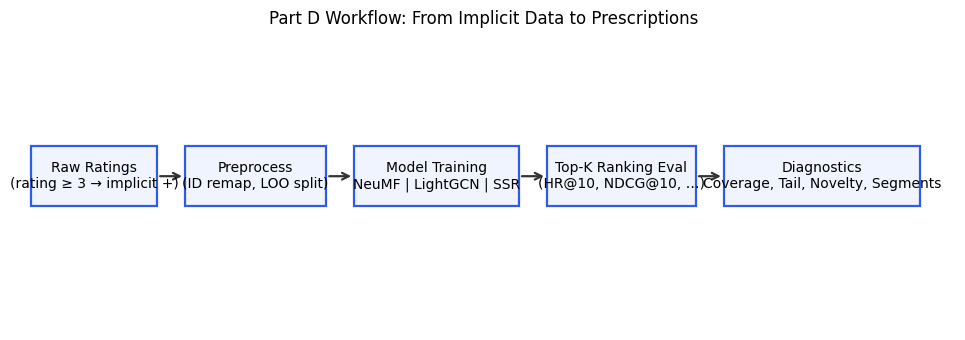

Saved: /content/partD_figures/F1_workflow.png


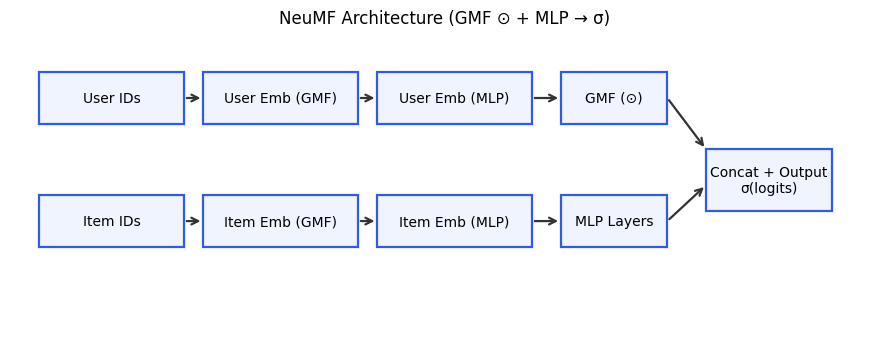

Saved: /content/partD_figures/F2_arch_neumf.png


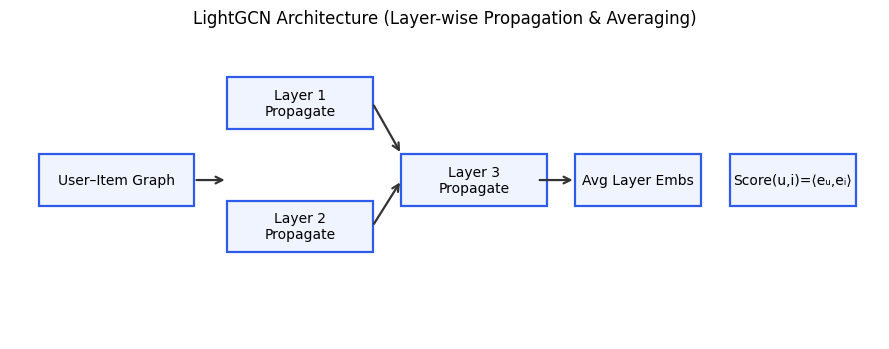

Saved: /content/partD_figures/F3_arch_lightgcn.png


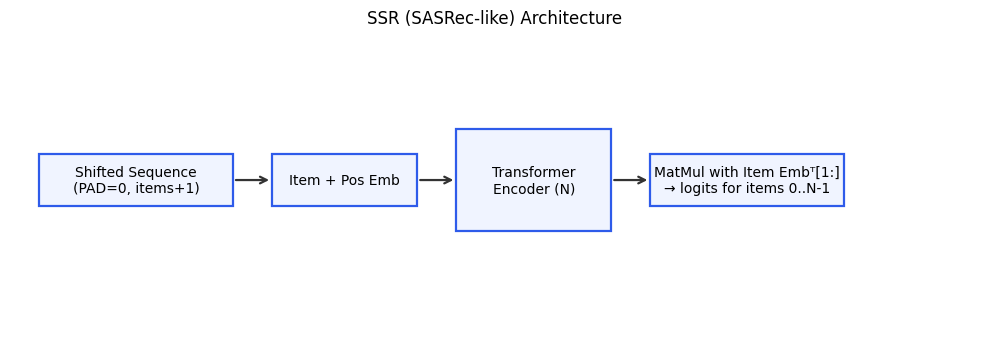

Saved: /content/partD_figures/F4_arch_ssr.png


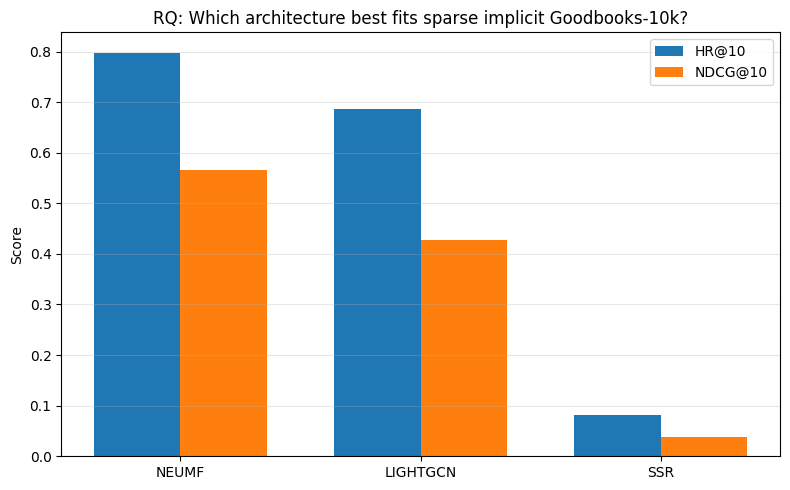

Saved: /content/partD_figures/F5_models_hr_ndcg.png


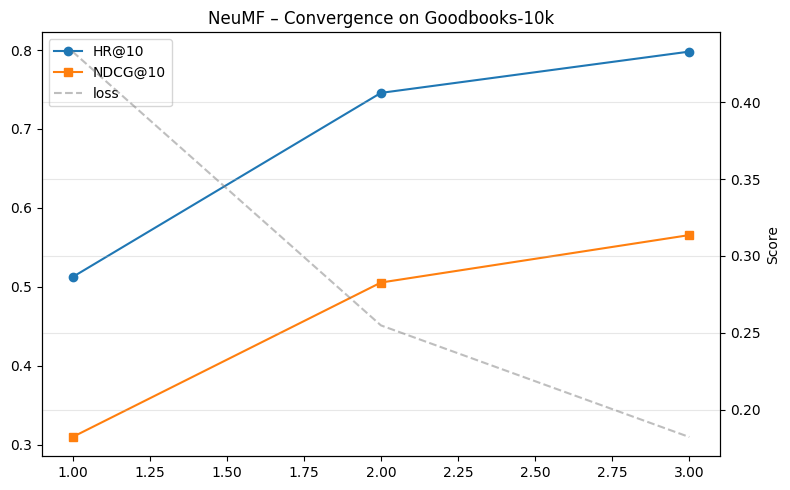

Saved: /content/partD_figures/F6_epochs_neumf.png


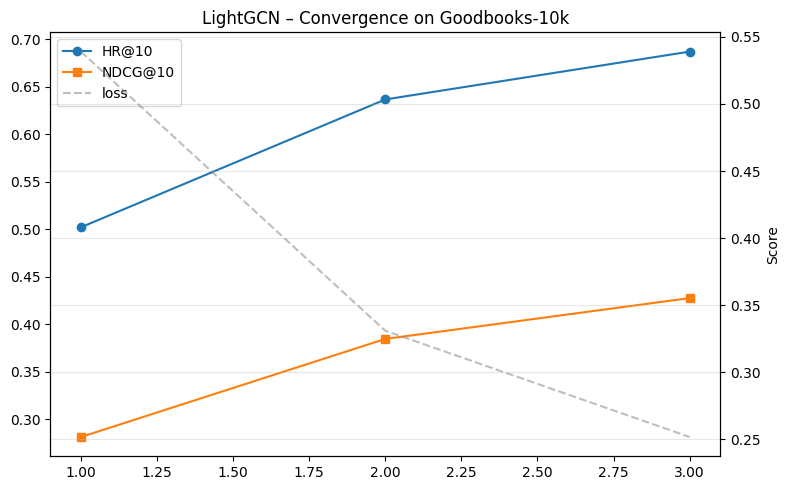

Saved: /content/partD_figures/F7_epochs_lightgcn.png


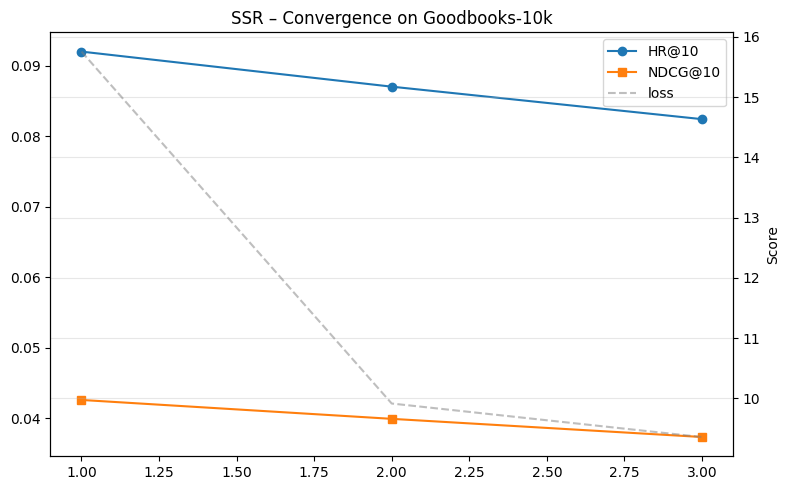

Saved: /content/partD_figures/F8_epochs_ssr.png


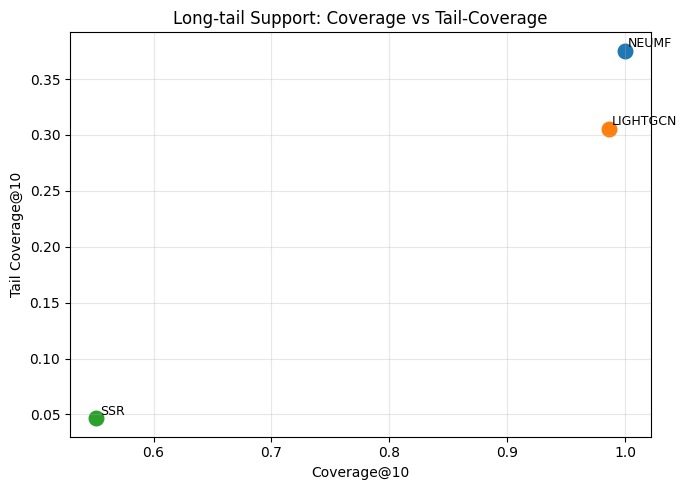

Saved: /content/partD_figures/F9_coverage_tail.png


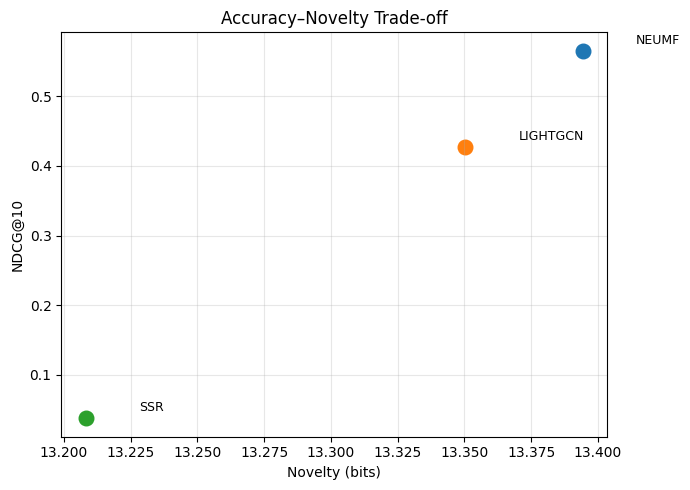

Saved: /content/partD_figures/F10_novelty_ndcg.png


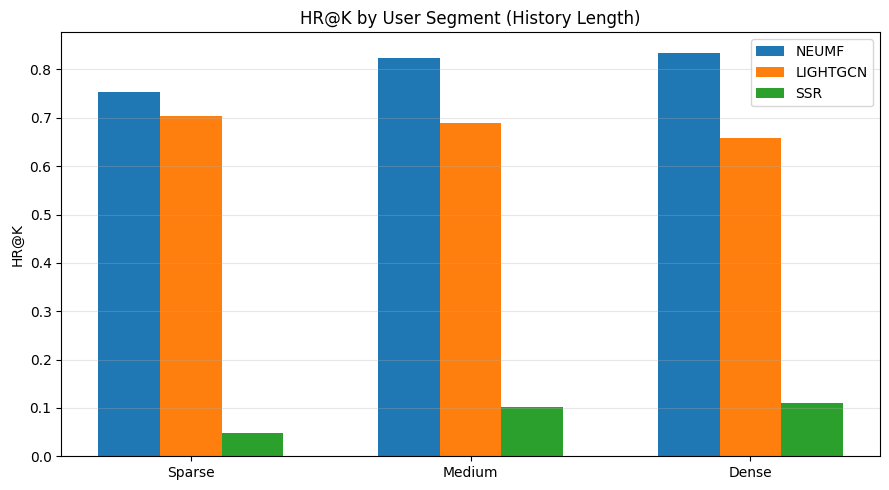

Saved: /content/partD_figures/F11_segments_hr.png


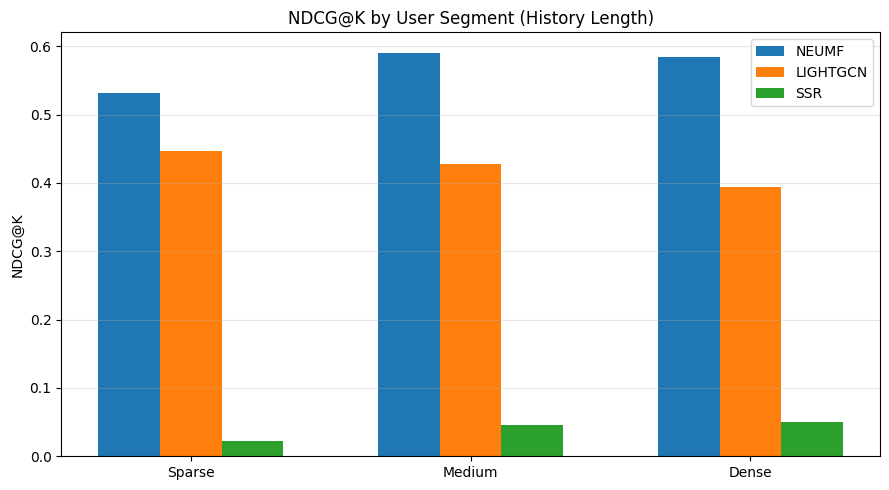

Saved: /content/partD_figures/F12_segments_ndcg.png

All figures saved to: /content/partD_figures


In [ ]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

OUTDIR = "/content/partD_figures"
INDIR  = "/content/partD_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# Load artifacts
def _load_csv(path):
    return pd.read_csv(path) if os.path.exists(path) else None

summary = _load_csv(f"{INDIR}/summary_all_models.csv")
m_neumf = _load_csv(f"{INDIR}/metrics_neumf.csv")
m_lgcn  = _load_csv(f"{INDIR}/metrics_lightgcn.csv")
m_ssr   = _load_csv(f"{INDIR}/metrics_ssr.csv")

seg_path = f"{INDIR}/segment_eval.json"
segments = json.load(open(seg_path)) if os.path.exists(seg_path) else None

# Keep only implemented models
MODEL_ORDER = ["neumf", "lightgcn", "ssr"]
if summary is not None:
    summary = summary[summary["model"].isin(MODEL_ORDER)].copy()
    summary["model"] = pd.Categorical(summary["model"], categories=MODEL_ORDER, ordered=True)
    summary = summary.sort_values("model")

# Helpers for diagrams
def draw_box(ax, xy, w, h, text, fc="#f0f4ff", ec="#2e5bea", lw=1.6, fs=10):
    r = Rectangle(xy, w, h, facecolor=fc, edgecolor=ec, lw=lw)
    ax.add_patch(r)
    ax.text(xy[0]+w/2, xy[1]+h/2, text, ha="center", va="center", fontsize=fs)

def arrow(ax, xy1, xy2, color="#333", lw=1.6):
    ax.add_patch(FancyArrowPatch(xy1, xy2, arrowstyle="->", mutation_scale=12, lw=lw, color=color))

def save_show(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=220, bbox_inches="tight")
    plt.show()
    print("Saved:", path)

# Project workflow diagram
fig, ax = plt.subplots(figsize=(10, 3.5))
ax.set_xlim(0, 24); ax.set_ylim(0, 6); ax.axis("off")
draw_box(ax, (0.5, 2.5), 3.2, 1.2, "Raw Ratings\n(rating ≥ 3 → implicit +)")
arrow(ax, (3.7, 3.1), (4.4, 3.1))
draw_box(ax, (4.4, 2.5), 3.6, 1.2, "Preprocess\n(ID remap, LOO split)")
arrow(ax, (8.0, 3.1), (8.7, 3.1))
draw_box(ax, (8.7, 2.5), 4.2, 1.2, "Model Training\nNeuMF | LightGCN | SSR")
arrow(ax, (12.9, 3.1), (13.6, 3.1))
draw_box(ax, (13.6, 2.5), 3.8, 1.2, "Top-K Ranking Eval\n(HR@10, NDCG@10, …)")
arrow(ax, (17.4, 3.1), (18.1, 3.1))
draw_box(ax, (18.1, 2.5), 5.0, 1.2, "Diagnostics\nCoverage, Tail, Novelty, Segments")
ax.set_title("Part D Workflow: From Implicit Data to Prescriptions")
save_show(fig, f"{OUTDIR}/F1_workflow.png")

# NeuMF architecture
fig, ax = plt.subplots(figsize=(9, 3.6))
ax.set_xlim(0, 18); ax.set_ylim(0, 6); ax.axis("off")
draw_box(ax, (0.6, 4.2), 3.0, 1.0, "User IDs")
draw_box(ax, (0.6, 1.8), 3.0, 1.0, "Item IDs")
draw_box(ax, (4.0, 4.2), 3.2, 1.0, "User Emb (GMF)")
draw_box(ax, (4.0, 1.8), 3.2, 1.0, "Item Emb (GMF)")
draw_box(ax, (7.6, 4.2), 3.2, 1.0, "User Emb (MLP)")
draw_box(ax, (7.6, 1.8), 3.2, 1.0, "Item Emb (MLP)")
arrow(ax, (3.6, 4.7), (4.0, 4.7)); arrow(ax, (3.6, 2.3), (4.0, 2.3))
arrow(ax, (7.2, 4.7), (7.6, 4.7)); arrow(ax, (7.2, 2.3), (7.6, 2.3))
draw_box(ax, (11.4, 4.2), 2.2, 1.0, "GMF (⊙)")
draw_box(ax, (11.4, 1.8), 2.2, 1.0, "MLP Layers")
arrow(ax, (10.8, 4.7), (11.4, 4.7)); arrow(ax, (10.8, 2.3), (11.4, 2.3))
draw_box(ax, (14.4, 2.5), 2.6, 1.2, "Concat + Output\nσ(logits)")
arrow(ax, (13.6, 4.7), (14.4, 3.7)); arrow(ax, (13.6, 2.3), (14.4, 3.0))
ax.set_title("NeuMF Architecture (GMF ⊙ + MLP → σ)")
save_show(fig, f"{OUTDIR}/F2_arch_neumf.png")

# LightGCN architecture
fig, ax = plt.subplots(figsize=(9, 3.6))
ax.set_xlim(0, 18); ax.set_ylim(0, 6); ax.axis("off")
draw_box(ax, (0.6, 2.6), 3.2, 1.0, "User–Item Graph")
arrow(ax, (3.8, 3.1), (4.5, 3.1))
draw_box(ax, (4.5, 4.1), 3.0, 1.0, "Layer 1\nPropagate")
draw_box(ax, (4.5, 1.7), 3.0, 1.0, "Layer 2\nPropagate")
draw_box(ax, (8.1, 2.6), 3.0, 1.0, "Layer 3\nPropagate")
arrow(ax, (7.5, 4.6), (8.1, 3.6)); arrow(ax, (7.5, 2.2), (8.1, 3.1))
draw_box(ax, (11.7, 2.6), 2.6, 1.0, "Avg Layer Embs")
arrow(ax, (10.9, 3.1), (11.7, 3.1))
draw_box(ax, (14.9, 2.6), 2.6, 1.0, "Score(u,i)=⟨eᵤ,eᵢ⟩")
ax.set_title("LightGCN Architecture (Layer-wise Propagation & Averaging)")
save_show(fig, f"{OUTDIR}/F3_arch_lightgcn.png")

# SSR architecture
fig, ax = plt.subplots(figsize=(10, 3.6))
ax.set_xlim(0, 20); ax.set_ylim(0, 6); ax.axis("off")
draw_box(ax, (0.6, 2.6), 4.0, 1.0, "Shifted Sequence\n(PAD=0, items+1)")
arrow(ax, (4.6, 3.1), (5.4, 3.1))
draw_box(ax, (5.4, 2.6), 3.0, 1.0, "Item + Pos Emb")
arrow(ax, (8.4, 3.1), (9.2, 3.1))
draw_box(ax, (9.2, 2.1), 3.2, 2.0, "Transformer\nEncoder (N)")
arrow(ax, (12.4, 3.1), (13.2, 3.1))
draw_box(ax, (13.2, 2.6), 4.0, 1.0, "MatMul with Item Embᵀ[1:]\n→ logits for items 0..N-1")
ax.set_title("SSR (SASRec-like) Architecture")
save_show(fig, f"{OUTDIR}/F4_arch_ssr.png")

# Model comparison bar chart
def bar_compare(df):
    if df is None or len(df)==0:
        print("summary_all_models.csv missing/empty"); return
    labels = [m.upper() for m in df["model"]]
    hr = df["HR@K"].astype(float).values
    nd = df["NDCG@K"].astype(float).values
    x = np.arange(len(labels)); w=0.36
    plt.figure(figsize=(8,5))
    plt.bar(x - w/2, hr, width=w, label="HR@10")
    plt.bar(x + w/2, nd, width=w, label="NDCG@10")
    plt.xticks(x, labels); plt.ylabel("Score")
    plt.title("RQ: Which architecture best fits sparse implicit Goodbooks-10k?")
    plt.grid(axis='y', alpha=0.3); plt.legend(); plt.tight_layout()
    path = f"{OUTDIR}/F5_models_hr_ndcg.png"; plt.savefig(path, dpi=220); plt.show(); print("Saved:", path)

bar_compare(summary)

# Per-epoch curves
def epoch_curves(df, name, fname):
    if df is None or "epoch" not in df.columns:
        print(f"metrics for {name} missing"); return
    d = df.copy()
    if d["epoch"].dtype!=int and d["epoch"].dtype!=np.int64:
        d["epoch"] = d["epoch"].astype(int)
    if d["epoch"].max() > 0:
        d = d[d["epoch"]>=1]
    plt.figure(figsize=(8,5))
    plt.plot(d["epoch"], d["HR@K"], marker='o', label="HR@10")
    plt.plot(d["epoch"], d["NDCG@K"], marker='s', label="NDCG@10")
    if "loss" in d.columns and d["loss"].notna().any():
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax2.plot(d["epoch"], d["loss"], linestyle='--', alpha=0.5, label="loss", color="tab:gray")
        ax2.set_ylabel("Loss")
        h1,l1 = ax1.get_legend_handles_labels()
        h2,l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="best")
    else:
        plt.legend(loc="best")
    plt.xlabel("Epoch"); plt.ylabel("Score"); plt.grid(alpha=0.3)
    plt.title(f"{name} – Convergence on Goodbooks-10k")
    plt.tight_layout()
    path = f"{OUTDIR}/{fname}"; plt.savefig(path, dpi=220); plt.show(); print("Saved:", path)

epoch_curves(m_neumf, "NeuMF",    "F6_epochs_neumf.png")
epoch_curves(m_lgcn,  "LightGCN", "F7_epochs_lightgcn.png")
epoch_curves(m_ssr,   "SSR",      "F8_epochs_ssr.png")

# Coverage vs Tail-Coverage
def cov_tail(df):
    if df is None or not {"Coverage@K","TailCov@K","model"}.issubset(df.columns): return
    plt.figure(figsize=(7,5))
    for _, r in df.iterrows():
        plt.scatter(r["Coverage@K"], r["TailCov@K"], s=110)
        plt.text(r["Coverage@K"]+0.003, r["TailCov@K"]+0.003, r["model"].upper(), fontsize=9)
    plt.xlabel("Coverage@10"); plt.ylabel("Tail Coverage@10")
    plt.title("Long-tail Support: Coverage vs Tail-Coverage")
    plt.grid(alpha=0.3); plt.tight_layout()
    path = f"{OUTDIR}/F9_coverage_tail.png"; plt.savefig(path, dpi=220); plt.show(); print("Saved:", path)

cov_tail(summary)

#  Novelty vs NDCG
def novelty_ndcg(df):
    if df is None or not {"Novelty(bits)","NDCG@K","model"}.issubset(df.columns): return
    plt.figure(figsize=(7,5))
    for _, r in df.iterrows():
        plt.scatter(r["Novelty(bits)"], r["NDCG@K"], s=110)
        plt.text(r["Novelty(bits)"]+0.02, r["NDCG@K"]+0.01, r["model"].upper(), fontsize=9)
    plt.xlabel("Novelty (bits)"); plt.ylabel("NDCG@10")
    plt.title("Accuracy–Novelty Trade-off")
    plt.grid(alpha=0.3); plt.tight_layout()
    path = f"{OUTDIR}/F10_novelty_ndcg.png"; plt.savefig(path, dpi=220); plt.show(); print("Saved:", path)

novelty_ndcg(summary)

# Segment performance
def segment_plot(segments, metric, fname):
    if not segments:
        print("segment_eval.json missing."); return
    models = [m for m in MODEL_ORDER if m in segments]
    segs = ["sparse","medium","dense"]
    data = {m:[] for m in models}
    for m in models:
        for s in segs:
            v = segments[m].get(s) if segments.get(m) else None
            data[m].append(np.nan if v is None else float(v.get(metric, np.nan)))
    X = np.arange(len(segs)); w = 0.22
    plt.figure(figsize=(9,5))
    for i,m in enumerate(models):
        plt.bar(X + (i - (len(models)-1)/2)*w, data[m], width=w, label=m.upper())
    plt.xticks(X, [s.title() for s in segs]); plt.ylabel(metric)
    plt.title(f"{metric} by User Segment (History Length)")
    plt.grid(axis='y', alpha=0.3); plt.legend(); plt.tight_layout()
    path = f"{OUTDIR}/{fname}"; plt.savefig(path, dpi=220); plt.show(); print("Saved:", path)

segment_plot(segments, "HR@K",    "F11_segments_hr.png")
segment_plot(segments, "NDCG@K",  "F12_segments_ndcg.png")

print("\nAll figures saved to:", OUTDIR)



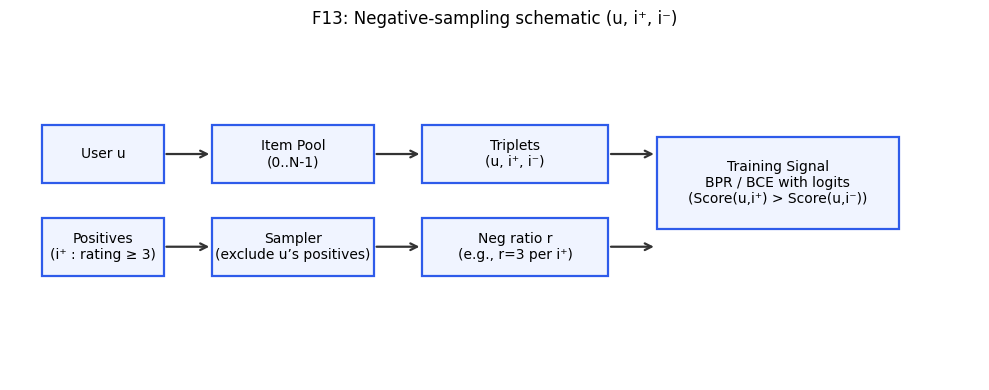

Saved: /content/partD_figures/F13_negative_sampling.png


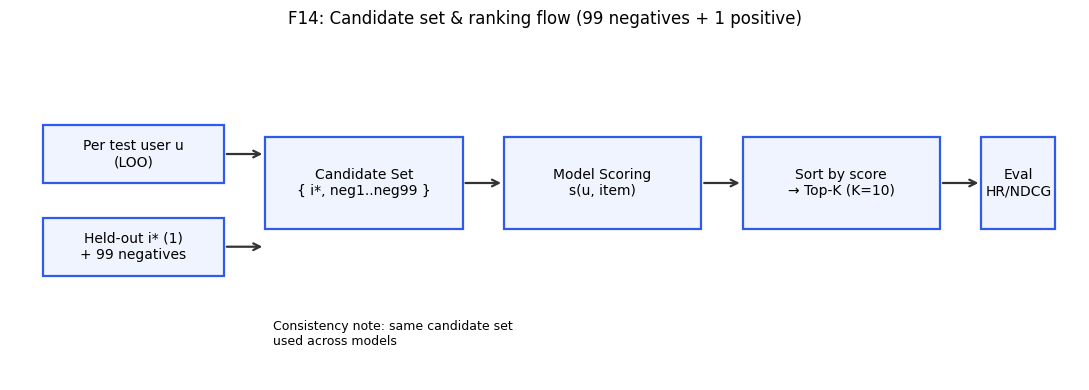

Saved: /content/partD_figures/F14_candidate_ranking.png


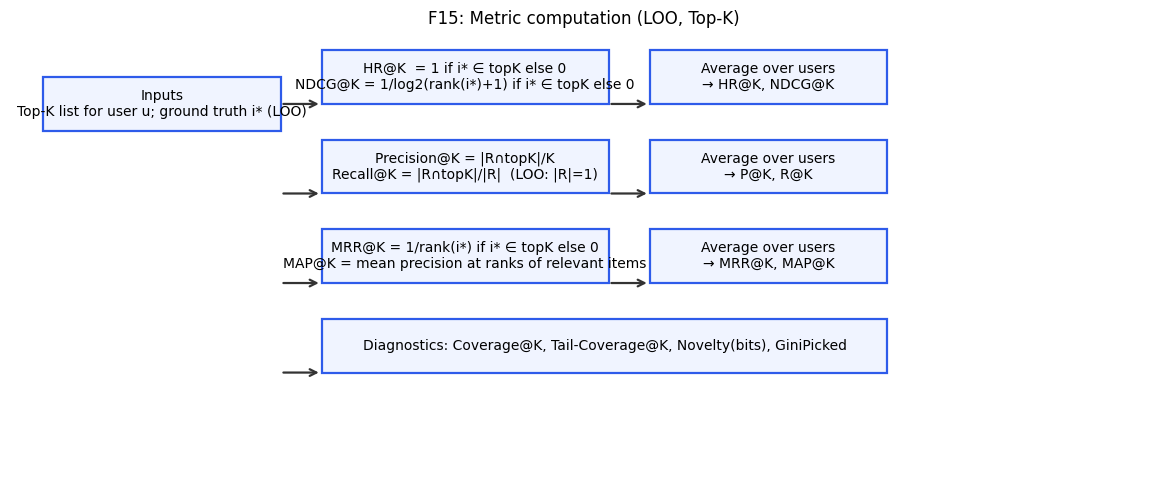

Saved: /content/partD_figures/F15_metrics_pipeline.png


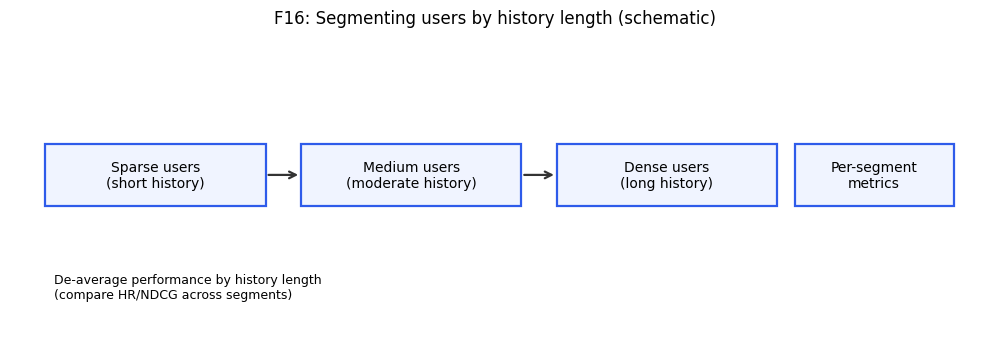

Saved: /content/partD_figures/F16_segments_schematic.png

All new figures are in: /content/partD_figures


In [3]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

FIGDIR = "/content/partD_figures"
OUTDIR = "/content/partD_outputs"
os.makedirs(FIGDIR, exist_ok=True)

# helpers
def draw_box(ax, xy, w, h, text, fc="#f0f4ff", ec="#2e5bea", lw=1.6, fs=10):
    r = Rectangle(xy, w, h, facecolor=fc, edgecolor=ec, lw=lw)
    ax.add_patch(r)
    ax.text(xy[0]+w/2, xy[1]+h/2, text, ha="center", va="center", fontsize=fs)

def arrow(ax, xy1, xy2, color="#333", lw=1.6):
    ax.add_patch(FancyArrowPatch(xy1, xy2, arrowstyle="->", mutation_scale=12, lw=lw, color=color))

def savefig(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=220, bbox_inches="tight")
    plt.show()
    print("Saved:", path)

# Try to load segments meta
segments_path = os.path.join(OUTDIR, "segment_eval.json")
segments = None
if os.path.exists(segments_path):
    try:
        with open(segments_path, "r") as f:
            segments = json.load(f)
    except Exception as e:
        print("Could not read segment_eval.json:", e)

# Negative-sampling schematic
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim(0, 24); ax.set_ylim(0, 6); ax.axis("off")

# user and positives
draw_box(ax, (0.8, 3.4), 3.0, 1.0, "User u")
draw_box(ax, (0.8, 1.8), 3.0, 1.0, "Positives\n(i⁺ : rating ≥ 3)")
arrow(ax, (3.8, 3.9), (5.0, 3.9))
arrow(ax, (3.8, 2.3), (5.0, 2.3))

# pool and negative sampler
draw_box(ax, (5.0, 3.4), 4.0, 1.0, "Item Pool\n(0..N-1)")
draw_box(ax, (5.0, 1.8), 4.0, 1.0, "Sampler\n(exclude u’s positives)")
arrow(ax, (9.0, 3.9), (10.2, 3.9))
arrow(ax, (9.0, 2.3), (10.2, 2.3))

# outputs: triplets
draw_box(ax, (10.2, 3.4), 4.6, 1.0, "Triplets\n(u, i⁺, i⁻)")
draw_box(ax, (10.2, 1.8), 4.6, 1.0, "Neg ratio r\n(e.g., r=3 per i⁺)")
arrow(ax, (14.8, 3.9), (16.0, 3.9))
arrow(ax, (14.8, 2.3), (16.0, 2.3))

# loss hint
draw_box(ax, (16.0, 2.6), 6.0, 1.6, "Training Signal\nBPR / BCE with logits\n(Score(u,i⁺) > Score(u,i⁻))")

ax.set_title("F13: Negative-sampling schematic (u, i⁺, i⁻)")
savefig(fig, os.path.join(FIGDIR, "F13_negative_sampling.png"))

# Candidate set & ranking flow
fig, ax = plt.subplots(figsize=(11, 4))
ax.set_xlim(0, 26); ax.set_ylim(0, 6); ax.axis("off")

draw_box(ax, (0.8, 3.4), 4.4, 1.0, "Per test user u\n(LOO)")
draw_box(ax, (0.8, 1.8), 4.4, 1.0, "Held-out i* (1)\n+ 99 negatives")
arrow(ax, (5.2, 3.9), (6.2, 3.9))
arrow(ax, (5.2, 2.3), (6.2, 2.3))

draw_box(ax, (6.2, 2.6), 4.8, 1.6, "Candidate Set\n{ i*, neg1..neg99 }")
arrow(ax, (11.0, 3.4), (12.0, 3.4))

draw_box(ax, (12.0, 2.6), 4.8, 1.6, "Model Scoring\ns(u, item)")
arrow(ax, (16.8, 3.4), (17.8, 3.4))

draw_box(ax, (17.8, 2.6), 4.8, 1.6, "Sort by score\n→ Top-K (K=10)")
arrow(ax, (22.6, 3.4), (23.6, 3.4))

draw_box(ax, (23.6, 2.6), 1.8, 1.6, "Eval\nHR/NDCG")

ax.text(6.4, 0.8, "Consistency note: same candidate set\nused across models", fontsize=9, ha="left", va="center")
ax.set_title("F14: Candidate set & ranking flow (99 negatives + 1 positive)")
savefig(fig, os.path.join(FIGDIR, "F14_candidate_ranking.png"))

# Metric computation chart
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_xlim(0, 28); ax.set_ylim(0, 10); ax.axis("off")

draw_box(ax, (0.8, 7.8), 5.8, 1.2, "Inputs\nTop-K list for user u; ground truth i* (LOO)")
arrow(ax, (6.6, 8.4), (7.6, 8.4))

# Row 1: HR@K, NDCG@K
draw_box(ax, (7.6, 8.4), 7.0, 1.2, "HR@K  = 1 if i* ∈ topK else 0\nNDCG@K = 1/log2(rank(i*)+1) if i* ∈ topK else 0")
arrow(ax, (14.6, 8.4), (15.6, 8.4))
draw_box(ax, (15.6, 8.4), 5.8, 1.2, "Average over users\n→ HR@K, NDCG@K")

# Row 2: Precision/Recall
arrow(ax, (6.6, 6.4), (7.6, 6.4))
draw_box(ax, (7.6, 6.4), 7.0, 1.2, "Precision@K = |R∩topK|/K\nRecall@K = |R∩topK|/|R|  (LOO: |R|=1)")
arrow(ax, (14.6, 6.4), (15.6, 6.4))
draw_box(ax, (15.6, 6.4), 5.8, 1.2, "Average over users\n→ P@K, R@K")

# Row 3: MRR / MAP
arrow(ax, (6.6, 4.4), (7.6, 4.4))
draw_box(ax, (7.6, 4.4), 7.0, 1.2, "MRR@K = 1/rank(i*) if i* ∈ topK else 0\nMAP@K = mean precision at ranks of relevant items")
arrow(ax, (14.6, 4.4), (15.6, 4.4))
draw_box(ax, (15.6, 4.4), 5.8, 1.2, "Average over users\n→ MRR@K, MAP@K")

# Row 4: Diagnostics
arrow(ax, (6.6, 2.4), (7.6, 2.4))
draw_box(ax, (7.6, 2.4), 13.8, 1.2, "Diagnostics: Coverage@K, Tail-Coverage@K, Novelty(bits), GiniPicked")

ax.set_title("F15: Metric computation (LOO, Top-K)")
savefig(fig, os.path.join(FIGDIR, "F15_metrics_pipeline.png"))

# Segmenting users by history length
counts = None
thresholds = None
if isinstance(segments, dict):
    # Try a few reasonable keys
    if "_meta" in segments and isinstance(segments["_meta"], dict):
        counts = segments["_meta"].get("counts", None)
        thresholds = segments["_meta"].get("thresholds", None)
    # fallback: look for top-level 'counts'
    if counts is None and "counts" in segments:
        counts = segments["counts"]
    if thresholds is None and "thresholds" in segments:
        thresholds = segments["thresholds"]

if isinstance(counts, dict):
    # Bar chart of counts
    fig, ax = plt.subplots(figsize=(8, 4))
    segs = ["sparse", "medium", "dense"]
    vals = [counts.get(s, np.nan) for s in segs]
    ax.bar(np.arange(len(segs)), vals)
    ax.set_xticks(np.arange(len(segs))); ax.set_xticklabels([s.title() for s in segs])
    ax.set_ylabel("User count")
    title = "F16: Segments by history length"
    if isinstance(thresholds, dict):
        # Expect something like {"sparse":"≤2", "medium":"3–7", "dense":"≥8"} or actual numbers
        title += f"  (bins: {thresholds})"
    ax.set_title(title)
    ax.grid(axis='y', alpha=0.3)
    savefig(fig, os.path.join(FIGDIR, "F16_segments_counts.png"))
else:
    # Schematic if counts not available
    fig, ax = plt.subplots(figsize=(10, 3.6))
    ax.set_xlim(0, 22); ax.set_ylim(0, 6); ax.axis("off")
    draw_box(ax, (0.8, 2.6), 5.0, 1.2, "Sparse users\n(short history)")
    arrow(ax, (5.8, 3.2), (6.6, 3.2))
    draw_box(ax, (6.6, 2.6), 5.0, 1.2, "Medium users\n(moderate history)")
    arrow(ax, (11.6, 3.2), (12.4, 3.2))
    draw_box(ax, (12.4, 2.6), 5.0, 1.2, "Dense users\n(long history)")
    draw_box(ax, (17.8, 2.6), 3.6, 1.2, "Per-segment\nmetrics")
    ax.text(1.0, 0.8, "De-average performance by history length\n(compare HR/NDCG across segments)", fontsize=9)
    ax.set_title("F16: Segmenting users by history length (schematic)")
    savefig(fig, os.path.join(FIGDIR, "F16_segments_schematic.png"))

print("\nAll new figures are in:", FIGDIR)
